In [1]:
from abc import ABC, abstractmethod
import os
import sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
from bbtoolkit.preprocessing.environment import GeometryFactory
from utils.environment import get_geometry_by_name, StandardBuildingGeometryProcessor, get_geometry_name
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
import configparser
from typing import Any, Callable, Optional
from bbtoolkit.data.configparser import EvalConfigParser
from bbtoolkit.preprocessing.environment import AbstractBuildingGeometryProcessor, GeometryParams, TrainingSpace, get_geometry_params


In [2]:
class DefaultGeometryFactory(GeometryFactory):
    """
    A factory class for creating instances of the `Geometry` class based on configuration and processing functions.
    This class is a wrapper for its parent with default arguments

    Attributes:
        cfg_path (str): The file path to the configuration used to create the geometry.
        geometry_getter (Callable): A callable function that retrieves geometric parameters and the number of textures.
        building_geometry_processor (Callable): A callable function that processes geometric parameters into a training space.

    Methods:
        __call__(self, getter_kwargs: dict[str, Any] = None, building_processor_kwargs: dict[str, Any] = None) -> Geometry:
            Create and return a `Geometry` instance based on the provided configuration and processing functions.

    Example:
        >>> factory = GeometryFactory(
        >>>     cfg_path="geometry_config.ini",
        >>>     geometry_getter=get_geometry_by_name,
        >>>     building_geometry_processor=StandartBuildingGeometryProcessor,
        >>> )
    """
    def __init__(
        self,
        cfg: str | configparser.ConfigParser,
        geometry_getter: Callable[[tuple[Any, ...]], tuple[GeometryParams, int]] = None,
        building_geometry_processor: Callable[
            [
                GeometryParams,
                float,
                AbstractBuildingGeometryProcessor,
                Optional[tuple[Any, ...]],
                Optional[dict[str, Any]]
            ], TrainingSpace
        ] = None,
    ):
        """
        Initialize the DefaultGeometryFactory.

        Args:
            cfg (str | configparser.ConfigParser): Config or the path to the configuration file used to create the geometry.
            geometry_getter (Callable, optional): A function that retrieves geometric parameters and the number of textures based on the configuration file (default is get_geometry_by_name).
            building_geometry_processor (Callable, optional): A function that processes geometric parameters into a training space (default is StandartBuildingGeometryProcessor).
        """
        if geometry_getter is None:
            geometry_getter = get_geometry_by_name
        if building_geometry_processor is None:
            building_geometry_processor = StandardBuildingGeometryProcessor

        super().__init__(cfg, geometry_getter, building_geometry_processor)

    def __call__(self, geometry_name: str):
        """
        Create and return a `Geometry` instance based on the provided configuration and processing functions.

        Args:
            geometry_name (str): The name of the standard building geometry. Must be one of:
            - 'two_room'
            - 'squared_room'
            - 'inserted_barrier'
            - 'preplay_env_open'
            - 'preplay_env_closed'
        Returns:
            Geometry: A `Geometry` instance representing the processed geometry.
        """
        return super().__call__(
            dict(geometry_name=geometry_name),
            dict(geometry_name=geometry_name)
        )

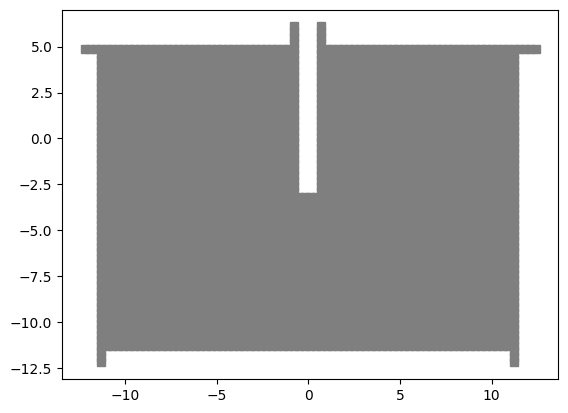

In [2]:
from utils.environment import StandardGeometryFactory


geometry = StandardGeometryFactory(f'../cfg/envs/two_room.ini')('two_room')
fig = geometry.training_space.plot()

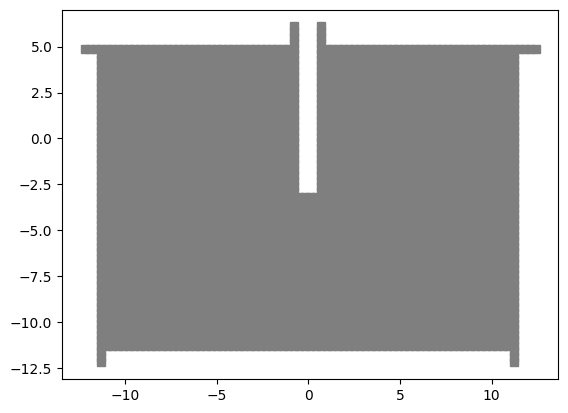

In [5]:
wts_cfg_path = '../cfg/envs/wts.ini'

geometry_name = 'two_room'
# geometry_name = 'inserted_barrier'
# geometry_name = 'squared_room'
room_cfg = f'../cfg/envs/{geometry_name}.ini'
# room_cfg = '../cfg/envs/two_room.ini'
res = .3
# kwargs = dict(geometry_name=get_geometry_name(wts_cfg_path))
kwargs = dict(geometry_name=geometry_name)
geometry = GeometryFactory(
    room_cfg,
    get_geometry_by_name,
    StandardBuildingGeometryProcessor
)(
    kwargs,
    kwargs
)
fig = geometry.training_space.plot()

In [ ]:
geometry = GeometryFactory(room_cfg)()

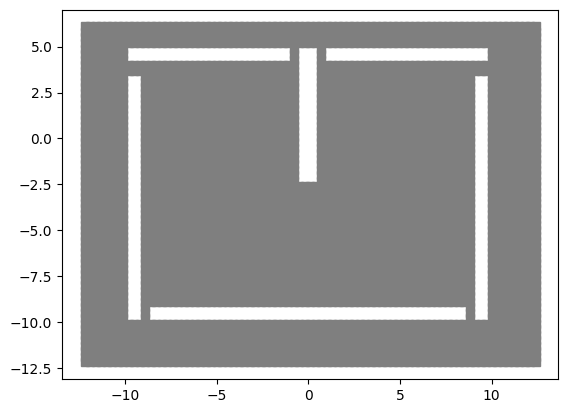

In [2]:
wts_cfg_path = '../cfg/envs/wts.ini'

geometry_name = 'two_room'
# geometry_name = 'inserted_barrier'
# geometry_name = 'squared_room'
room_cfg = f'../cfg/envs/{geometry_name}.ini'
# room_cfg = '../cfg/envs/two_room.ini'
res = .3
# kwargs = dict(geometry_name=get_geometry_name(wts_cfg_path))
kwargs = dict(geometry_name=geometry_name)
geometry = GeometryFactory(room_cfg)()
fig = geometry.training_space.plot()

In [11]:


@dataclass
class Object2D:
    """
    Represents a 2D object defined by X and Y coordinates.
    """
    x: tuple[float, ...]
    """
    X-coordinates of the vertices forming the 2D object.
    """
    y: tuple[float, ...]
    """
    Y-coordinates of the vertices forming the 2D object.
    """

    def __post_init__(self):
        """
        Validates and finalizes the object's vertex information.

        Raises:
            ValueError: If the number of X-coordinates does not match the number of Y-coordinates.
        Notes:
            If the X and Y coordinates do not form a closed shape, new point will be added.
        """
        if len(self.x) != len(self.y):
            raise ValueError(f'Dimension mismatch: x ({len(self.x)}) vs y ({len(self.y)})')

        if self.x[0] != self.x[-1] or self.y[0] != self.y[-1]:
            self.x = tuple(list(self.x) + [self.x[0]])
            self.y = tuple(list(self.y) + [self.y[0]])

        self.n_vertices = len(self.x)

def plot_environment(
    min_x: float,
    min_y: float,
    max_x: float,
    max_y: float,
    min_train_x: float,
    min_train_y: float,
    max_train_x: float,
    max_train_y: float,
    *args: Object2D,
    show: bool = False
) -> plt.Figure:
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.axis([min_x, max_x, min_y, max_y])
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_title('2D Layout of Environment')

    # Plot the environment boundaries
    ax.plot(
        [min_x, min_x, max_x, max_x, min_x],
        [min_y, max_y, max_y, min_y, min_y],
        '--', color='#888'
    )
    ax.plot(
        [min_train_x, min_train_x, max_train_x, max_train_x, min_train_x],
        [min_train_y, max_train_y, max_train_y, min_train_y, min_train_y],
        '--', color='tab:blue', label='Training area'
    )
    d = max_train_x - min_train_x
    ax.set_xlim(min_train_x - d * .05, max_train_x + d * .05)
    ax.set_ylim(min_train_y - d * .05, max_train_y + d * .05)

    label = 'Objects'
    for obj in args:
        # Plot each object as a polygon
        ax.plot(
            list(obj.x) + [obj.x[0]],
            list(obj.y) + [obj.y[0]],
            color='tab:red', label=label
        )
        label = ''

    ax.grid()
    ax.legend(loc='upper right')

    if show:
        plt.show()

    return fig


In [22]:

class EnvironmentBuilder:
    def __init__(
        self,
        xy_min: float,
        xy_max: float,
        xy_train_min: tuple[float, float] = None,
        xy_train_max: tuple[float, float] = None,
        res: float =  0.3,
    ) -> None:
        self.xy_min = xy_min
        self.xy_max = xy_max
        if xy_train_max is None:
            self.x_train_max, self.y_train_max = self.xy_max, self.xy_max
        else:
            self.x_train_max, self.y_train_max = xy_train_max
        if xy_train_min is None:
            self.x_train_min, self.y_train_min = self.xy_min, self.xy_min
        else:
            self.x_train_min, self.y_train_min = xy_train_min
        self.res = res
        self.objects = list()
        self.n_textures = None
        self.n_polygons = None

    def set_textures(self, n_textures: int):
        self.n_textures = n_textures
        return self

    def set_polygons(self, n_polygons: int):
        self.n_polygons = n_polygons
        return self

    def to_config(self) -> configparser.ConfigParser:
        parser = EvalConfigParser()
        parser.add_section('ExternalSources')
        parser.set('ExternalSources', 'paths', '')
        parser.set('ExternalSources', 'variables', '')

        parser.add_section('GridBoundaries')
        parser.set('GridBoundaries', 'max_xy', str(self.xy_max))
        parser.set('GridBoundaries', 'min_xy', str(self.xy_min))
        parser.set('GridBoundaries', 'res', str(self.res))

        parser.add_section('TrainingRectangle')
        parser.set('TrainingRectangle', 'min_train_x', str(self.x_train_min))
        parser.set('TrainingRectangle', 'min_train_y', str(self.y_train_min))
        parser.set('TrainingRectangle', 'max_train_x', str(self.x_train_max))
        parser.set('TrainingRectangle', 'max_train_y', str(self.y_train_max))

        parser.add_section('BuildingBoundaries')
        parser.set('BuildingBoundaries', 'max_n_obj_points', str(max([obj.n_vertices for obj in self.objects])))
        parser.set('BuildingBoundaries', 'n_objects', str(len(self.objects)))
        n_polygons = self.n_polygons if self.n_polygons is not None else len(self.objects)
        parser.set('BuildingBoundaries', 'n_polygons', str(n_polygons))
        n_textures = self.n_textures if self.n_textures is not None else len(self.objects)
        parser.set('BuildingBoundaries', 'n_textures', str(n_textures))

        for i, obj in enumerate(self.objects):
            parser.add_section(f'Object{i+1}')
            parser.set(f'Object{i+1}', 'n_vertices', str(obj.n_vertices))
            parser.set(f'Object{i+1}', 'object_x', str(obj.x)[1:-1])
            parser.set(f'Object{i+1}', 'object_y', str(obj.y)[1:-1])

        return parser

    def save(self, path: str):
        config = self.to_config()

        with open(path, 'w') as f:
            config.write(f)

    @staticmethod
    def load(path: str) -> 'EnvironmentBuilder':
        config = EvalConfigParser(interpolation=configparser.ExtendedInterpolation(), allow_no_value=True)
        config.read(path)
        return EnvironmentBuilder(
            config['GridBoundaries'].eval('min_xy'),
            config['GridBoundaries'].eval('max_xy'),
            (
                config['TrainingRectangle'].eval('min_train_x'),
                config['TrainingRectangle'].eval('min_train_y')
            ),
            (
                config['TrainingRectangle'].eval('max_train_x'),
                config['TrainingRectangle'].eval('max_train_y')
            ),
            config['GridBoundaries'].eval('res')
        ).add_object(
            *[
                Object2D(
                    config[f'Object{i}'].eval('object_x'),
                    config[f'Object{i}'].eval('object_y')
                )
                for i in range(1, config['BuildingBoundaries'].eval('n_objects')+1)
            ]
        )

    def add_object(self, *args: Object2D):
        self.objects += list(args)
        return self

    def plot(self, show: bool = False) -> plt.Figure:
        return plot_environment(
            self.xy_min, self.xy_min,
            self.xy_max, self.xy_max,
            self.x_train_min, self.y_train_min,
            self.x_train_max, self.y_train_max,
            *self.objects,
            show=show
        )
    def build(
        self,
        factory: GeometryFactory = GeometryFactory,
        geometry_getter: Callable[[tuple[Any, ...]], tuple[GeometryParams, int]] = None,
        building_geometry_processor: Callable[
            [
                GeometryParams,
                float,
                AbstractBuildingGeometryProcessor,
                Optional[tuple[Any, ...]],
                Optional[dict[str, Any]]
            ], TrainingSpace
        ] = None,
        *args,
        **kwargs
    ) -> GeometryFactory:
        return factory(self.to_config(), geometry_getter, building_geometry_processor, *args, **kwargs)

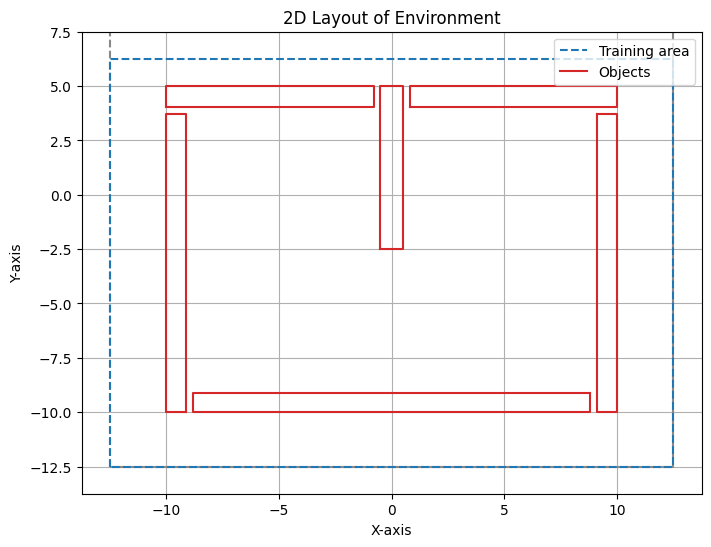

In [23]:
min_xy = -12.5
max_xy = 12.5
min_train_x = -12.5
min_train_y = -12.5
max_train_x = 12.5
max_train_y = 6.25

res = 0.3

builder = EnvironmentBuilder(
    min_xy,
    max_xy,
    (min_train_x, min_train_y),
    (max_train_x, max_train_y),
    res=res
)

builder.add_object(
    Object2D(
        (-10, -0.8, -0.8, -10, -10),
        (4.05, 4.05, 5, 5, 4.05)
    ),
    Object2D(
        (-0.5, 0.5, 0.5, -0.5, -0.5),
        (-2.5, -2.5, 5, 5, -2.5)
    ),
    Object2D(
        (0.8, 10, 10, 0.8, 0.8),
        (4.05, 4.05, 5, 5, 4.05)
    ),
    Object2D(
        (9.1, 10, 10, 9.1, 9.1),
        (3.7, 3.7, -10, -10, 3.7)
    ),
    Object2D(
        (8.8, 8.8, -8.8, -8.8, 8.8),
        (-9.1, -10, -10, -9.1, -9.1)
    ),
    Object2D(
        (-9.1, -10, -10, -9.1, -9.1),
        (-10, -10, 3.7, 3.7, -10)
    )
)
fig = builder.plot()

In [24]:
factory = builder.build()

In [25]:
geometry = factory()

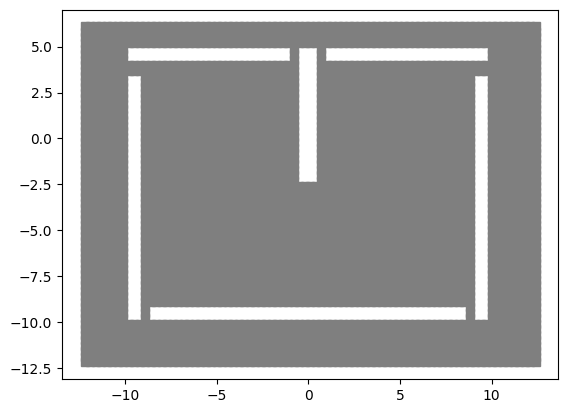

In [27]:
fig = geometry.training_space.plot()

In [60]:
builder.save('../cfg/envs/custom.ini')

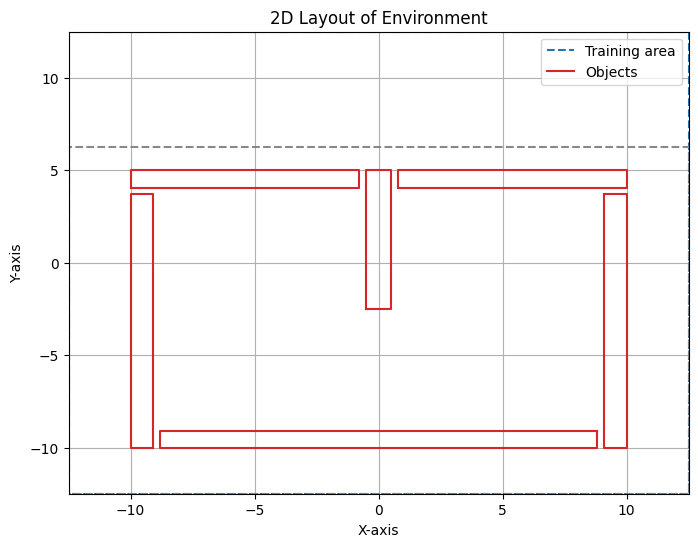

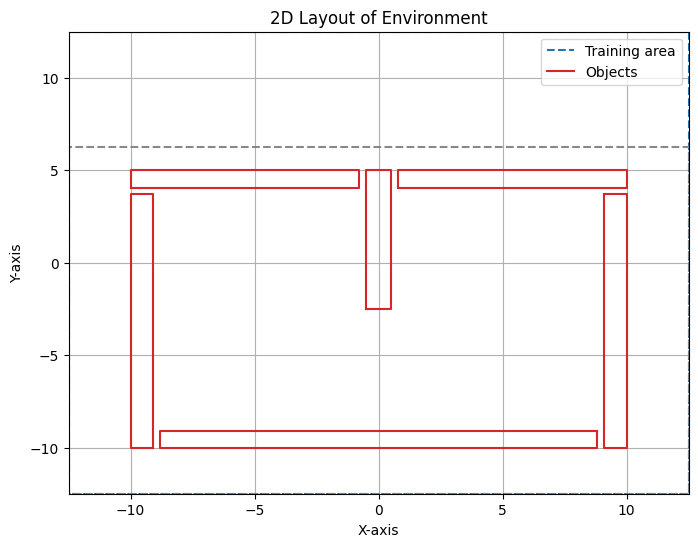

In [62]:
builder = EnvironmentBuilder.load('../cfg/envs/custom.ini')
builder.plot()